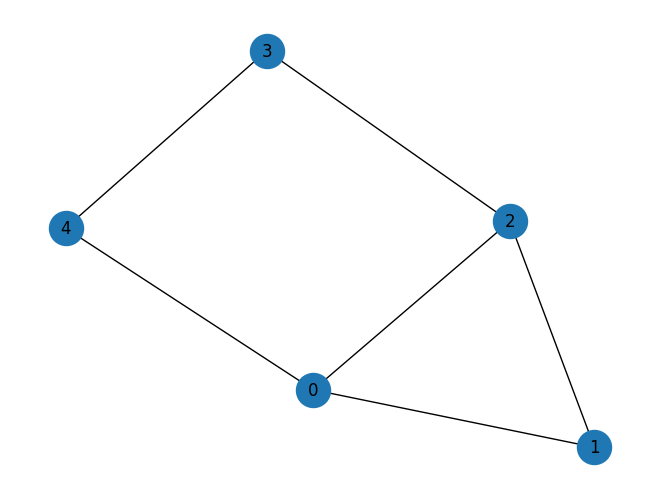

In [1]:
import rustworkx as rx
from rustworkx.visualization import mpl_draw as draw_graph
import numpy as np
from qiskit_ibm_runtime.fake_provider import FakeManilaV2

n = 5
fake=True
graph = rx.PyGraph()
graph.add_nodes_from(np.arange(0, n, 1))
edge_list = [(0, 1, 1.0), (0, 2, 1.0), (0, 4, 1.0), (1, 2, 1.0), (2, 3, 1.0), (3, 4, 1.0)]
graph.add_edges_from(edge_list)
draw_graph(graph, node_size=600, with_labels=True)

In [2]:
from qiskit.quantum_info import SparsePauliOp
def build_max_cut_paulis(graph: rx.PyGraph) -> list[tuple[str, float]]:
    """Convert the graph to Pauli list.

    This function does the inverse of `build_max_cut_graph`
    """
    pauli_list = []
    for edge in list(graph.edge_list()):
        paulis = ["I"] * len(graph)
        paulis[edge[0]], paulis[edge[1]] = "Z", "Z"

        weight = graph.get_edge_data(edge[0], edge[1])

        pauli_list.append(("".join(paulis)[::-1], weight))

    return pauli_list


max_cut_paulis = build_max_cut_paulis(graph)

cost_hamiltonian = SparsePauliOp.from_list(max_cut_paulis)
print("Cost Function Hamiltonian:", cost_hamiltonian)

Cost Function Hamiltonian: SparsePauliOp(['IIIZZ', 'IIZIZ', 'ZIIIZ', 'IIZZI', 'IZZII', 'ZZIII'],
              coeffs=[1.+0.j, 1.+0.j, 1.+0.j, 1.+0.j, 1.+0.j, 1.+0.j])


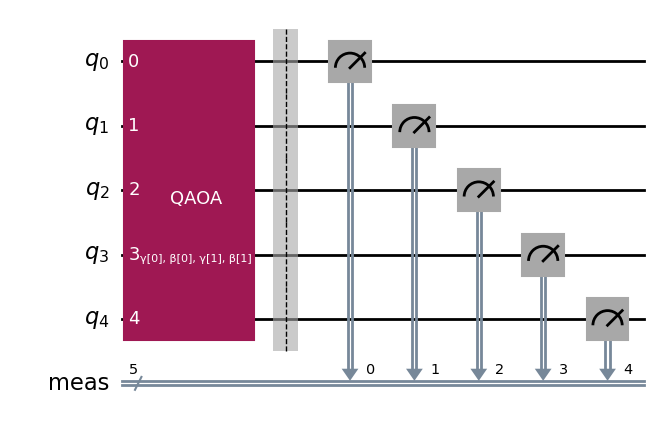

In [4]:
from qiskit.circuit.library import QAOAAnsatz

circuit = QAOAAnsatz(cost_operator=cost_hamiltonian, reps=2)
circuit.measure_all()

circuit.draw('mpl')

C:\Users\Artur\AppData\Local\Temp\ipykernel_22116\2772756902.py:6: DeprecationWarning: The "ibm_quantum" channel option is deprecated and will be sunset on 1 July. After this date, "ibm_cloud" and "local" will be the only valid channels. For information on migrating to the new IBM Quantum Platform on the "ibm_cloud" channel, review the migration guide https://quantum.cloud.ibm.com/docs/migration-guides/classic-iqp-to-cloud-iqp .
  service = QiskitRuntimeService(channel='ibm_quantum')


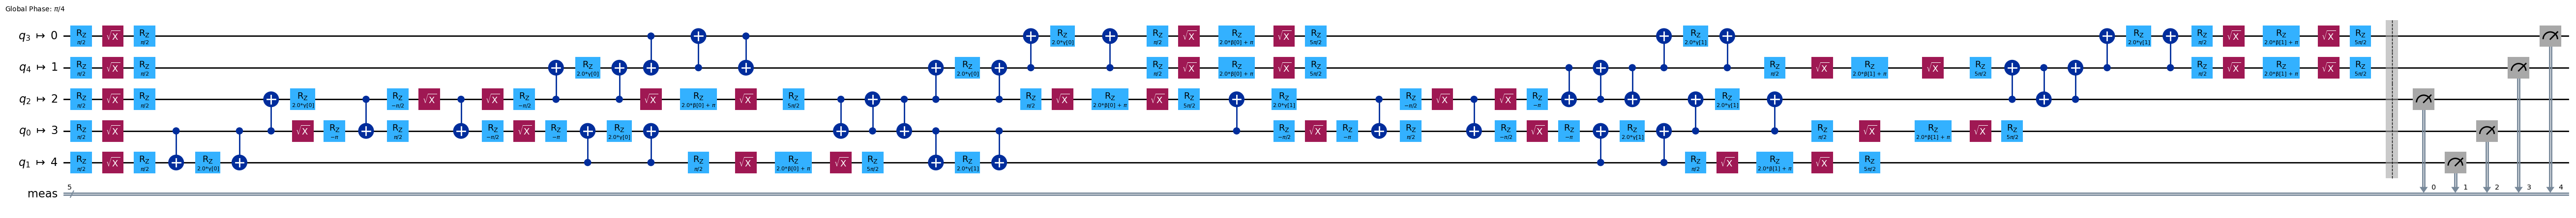

In [5]:
from qiskit_ibm_runtime import QiskitRuntimeService
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager


# QiskitRuntimeService.save_account(channel="ibm_quantum", token="<MY_IBM_QUANTUM_TOKEN>", overwrite=True, set_as_default=True)
service = QiskitRuntimeService(channel='ibm_quantum')
if not fake:
    backend = service.least_busy(min_num_qubits=127)
else:
    backend = FakeManilaV2()
print(backend)

# Create pass manager for transpilation
pm = generate_preset_pass_manager(optimization_level=3,
                                    backend=backend)

candidate_circuit = pm.run(circuit)
candidate_circuit.draw('mpl', fold=False, idle_wires=False)

In [6]:
initial_gamma = np.pi
initial_beta = np.pi/2
init_params = [initial_gamma, initial_beta, initial_gamma, initial_beta]

In [7]:
def cost_func_estimator(params, ansatz, hamiltonian, estimator):

    # transform the observable defined on virtual qubits to
    # an observable defined on all physical qubits
    isa_hamiltonian = hamiltonian.apply_layout(ansatz.layout)

    pub = (ansatz, isa_hamiltonian, params)
    job = estimator.run([pub])

    results = job.result()[0]
    cost = results.data.evs

    objective_func_vals.append(cost)


    return cost

In [8]:
from qiskit_ibm_runtime import Session, EstimatorV2 as Estimator
from scipy.optimize import minimize

objective_func_vals = [] # Global variable
with Session(backend=backend) as session:
    # If using qiskit-ibm-runtime<0.24.0, change `mode=` to `session=`
    estimator = Estimator(mode=FakeManilaV2())
    estimator.options.default_shots = 1000

    # Set simple error suppression/mitigation options
    estimator.options.dynamical_decoupling.enable = True
    estimator.options.dynamical_decoupling.sequence_type = "XY4"
    estimator.options.twirling.enable_gates = True
    estimator.options.twirling.num_randomizations = "auto"

    result = minimize(
        cost_func_estimator,
        init_params,
        args=(candidate_circuit, cost_hamiltonian, estimator),
        method="COBYLA",
        tol=1e-2,
    )
    print(result)

base_primitive._run:WARNING:2025-05-16 01:01:57,192: Even though a session/batch context manager is open this job will run in job mode because the estimator primitive was initialized outside the context manager. Move the estimator initialization inside the context manager to run in a session/batch.
d:\Courses\IBM Quantum Computing\.venv\Lib\site-packages\qiskit_ibm_runtime\fake_provider\local_service.py:269: UserWarning: Options {'dynamical_decoupling': {'enable': True, 'sequence_type': 'XY4'}, 'twirling': {'enable_gates': True, 'num_randomizations': 'auto'}} have no effect in local testing mode.
  warnings.warn(f"Options {options_copy} have no effect in local testing mode.")
base_primitive._run:WARNING:2025-05-16 01:01:57,214: Even though a session/batch context manager is open this job will run in job mode because the estimator primitive was initialized outside the context manager. Move the estimator initialization inside the context manager to run in a session/batch.
base_primitive.

 message: Optimization terminated successfully.
 success: True
  status: 1
     fun: -2.2817182817182817
       x: [ 4.365e+00  1.625e+00  3.405e+00  2.894e+00]
    nfev: 32
   maxcv: 0.0


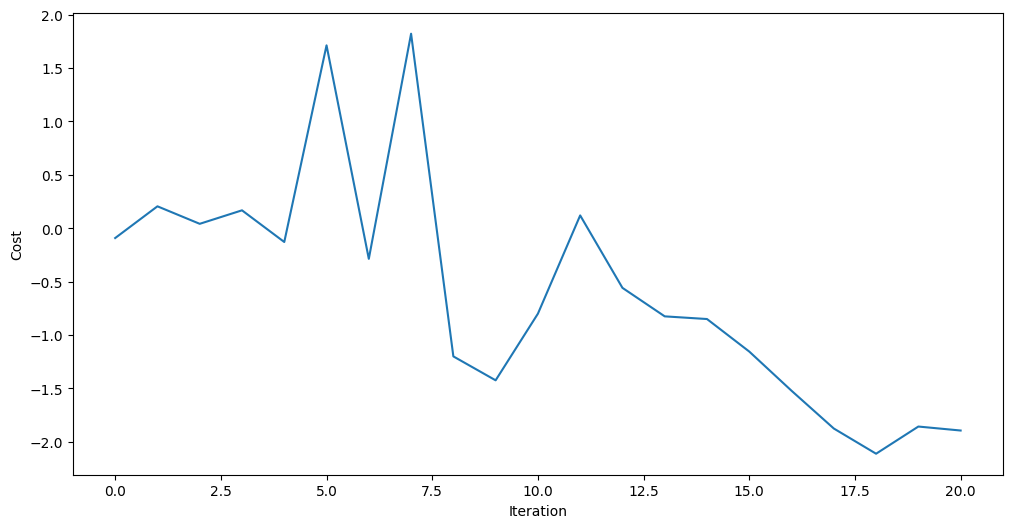

In [10]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
plt.plot(objective_func_vals)
plt.xlabel("Iteration")
plt.ylabel("Cost")
plt.show()

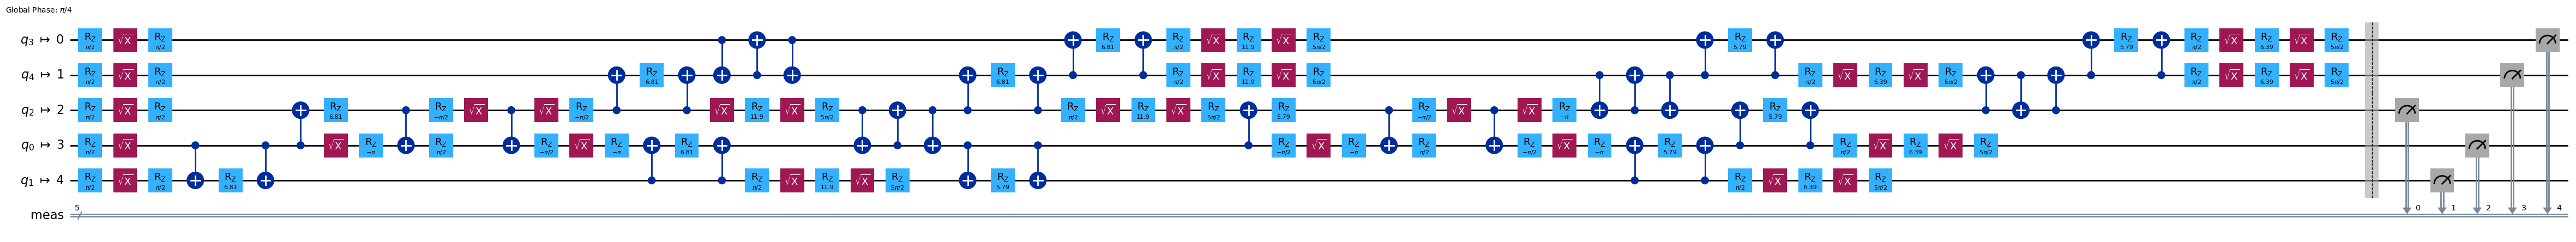

In [9]:
optimized_circuit = candidate_circuit.assign_parameters(result.x)
optimized_circuit.draw('mpl', fold=False, idle_wires=False)

In [11]:
from qiskit_ibm_runtime import SamplerV2 as Sampler

# If using qiskit-ibm-runtime<0.24.0, change `mode=` to `backend=`
sampler = Sampler(mode=backend)
sampler.options.default_shots = 10000

# Set simple error suppression/mitigation options
sampler.options.dynamical_decoupling.enable = True
sampler.options.dynamical_decoupling.sequence_type = "XY4"
sampler.options.twirling.enable_gates = True
sampler.options.twirling.num_randomizations = "auto"

pub= (optimized_circuit, )
job = sampler.run([pub], shots=int(1e4))
counts_int = job.result()[0].data.meas.get_int_counts()
counts_bin = job.result()[0].data.meas.get_counts()
shots = sum(counts_int.values())
final_distribution_int = {key: val/shots for key, val in counts_int.items()}
final_distribution_bin = {key: val/shots for key, val in counts_bin.items()}
print(final_distribution_int)

{13: 0.051, 11: 0.1012, 19: 0.0321, 9: 0.1039, 28: 0.0179, 5: 0.0709, 22: 0.102, 17: 0.0322, 10: 0.0524, 20: 0.102, 21: 0.0461, 30: 0.0091, 18: 0.0517, 26: 0.0675, 3: 0.0201, 4: 0.0088, 1: 0.0067, 14: 0.0301, 27: 0.0069, 24: 0.0059, 25: 0.02, 12: 0.0313, 0: 0.0024, 6: 0.0181, 31: 0.0029, 7: 0.0056, 8: 0.0004, 15: 0.0001, 16: 0.0002, 2: 0.0003, 23: 0.0002}


In [12]:
# auxiliary functions to sample most likely bitstring
def to_bitstring(integer, num_bits):
    result = np.binary_repr(integer, width=num_bits)
    return [int(digit) for digit in result]

keys = list(final_distribution_int.keys())
values = list(final_distribution_int.values())
most_likely = keys[np.argmax(np.abs(values))]
most_likely_bitstring = to_bitstring(most_likely, len(graph))
most_likely_bitstring.reverse()

print("Result bitstring:", most_likely_bitstring)

Result bitstring: [1, 0, 0, 1, 0]


C:\Users\Artur\AppData\Local\Temp\ipykernel_22116\3823459478.py:19: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  ax.get_children()[int(p)].set_color("tab:purple")


TypeError: only length-1 arrays can be converted to Python scalars

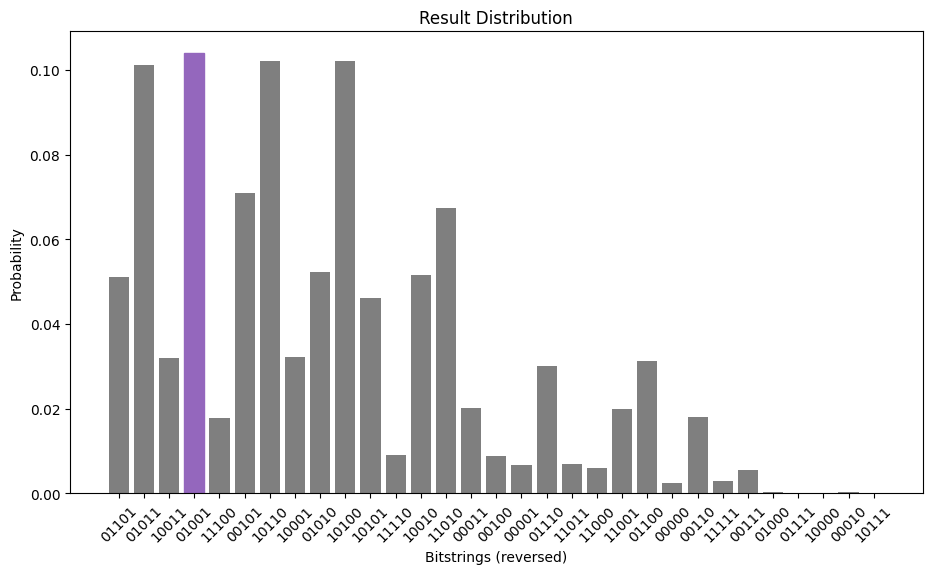

In [16]:
import matplotlib.pyplot as plt
import matplotlib

matplotlib.rcParams.update({"font.size": 10})
final_bits = final_distribution_bin
values = np.abs(list(final_bits.values()))
top_4_values = sorted(values, reverse=True)[:4]
positions = []
for value in top_4_values:
    positions.append(np.where(values == value)[0])
fig = plt.figure(figsize=(11, 6))
ax = fig.add_subplot(1, 1, 1)
plt.xticks(rotation=45)
plt.title("Result Distribution")
plt.xlabel("Bitstrings (reversed)")
plt.ylabel("Probability")
ax.bar(list(final_bits.keys()), list(final_bits.values()), color="tab:grey")
for p in positions:
    ax.get_children()[int(p)].set_color("tab:purple")
plt.show()

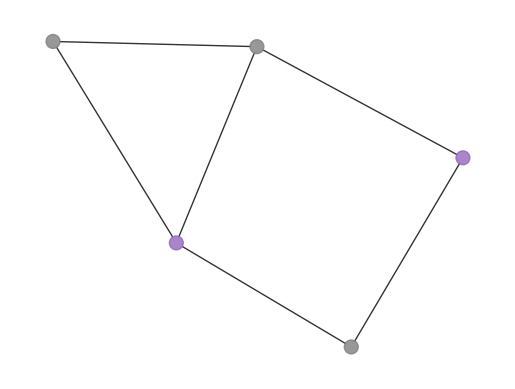

In [14]:
# auxiliary function to plot graphs
def plot_result(G, x):
    colors = ["tab:grey" if i == 0 else "tab:purple" for i in x]
    pos, default_axes = rx.spring_layout(G), plt.axes(frameon=True)
    rx.visualization.mpl_draw(G, node_color=colors, node_size=100, alpha=0.8, pos=pos)


plot_result(graph, most_likely_bitstring)

In [17]:
from typing import Sequence
def evaluate_sample(x: Sequence[int], graph: rx.PyGraph) -> float:
    assert len(x) == len(list(graph.nodes())), "The length of x must coincide with the number of nodes in the graph."
    return sum(x[u] * (1 - x[v]) + x[v] * (1 - x[u]) for u, v in list(graph.edge_list()))


cut_value= evaluate_sample(most_likely_bitstring, graph)
print('The value of the cut is:', cut_value)

The value of the cut is: 5
